In [3]:
import cv2
import numpy as np
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt

In [4]:
# 加载图像
image_path = '/Users/jiazhengtian/Desktop/image.png'

In [5]:
def boxes_in_image(image_path):
    """
    使用 PaddleOCR 检测图像中的文本框，并返回文本框的坐标、文本和置信度。

    参数:
        image_path (str): 图像文件的路径。

    返回:
        boxes (list): 检测到的文本框的四个顶点坐标。
        texts (list): 每个文本框的识别文本。
        scores (list): 每个文本框的置信度。
    """
    # 初始化 PaddleOCR
    ocr = PaddleOCR(use_angle_cls=True, lang="en")

    # 读取图像
    image = cv2.imread(image_path)
    
    # 使用 PaddleOCR 检测文本框
    result = ocr.ocr(image, cls=True)
    
    # 提取检测到的文本框
    boxes = [line[0] for line in result[0]]  # 每个文本框的四个顶点坐标
    texts = [line[1][0] for line in result[0]]  # 每个文本框的识别文本
    scores = [line[1][1] for line in result[0]]  # 每个文本框的置信度

    return boxes, texts, scores

In [6]:
boxes_in_image(image_path)

[2025/03/27 21:51:48] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/jiazhengtian/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/jiazhengtian/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

([[[178.0, 11.0], [228.0, 12.0], [228.0, 23.0], [178.0, 22.0]],
  [[120.0, 46.0], [149.0, 46.0], [149.0, 62.0], [120.0, 62.0]],
  [[249.0, 46.0], [293.0, 46.0], [293.0, 61.0], [249.0, 61.0]],
  [[175.0, 87.0], [232.0, 87.0], [232.0, 99.0], [175.0, 99.0]],
  [[48.0, 125.0], [90.0, 128.0], [89.0, 139.0], [48.0, 137.0]],
  [[183.0, 123.0], [224.0, 126.0], [223.0, 141.0], [182.0, 138.0]],
  [[316.0, 126.0], [359.0, 126.0], [359.0, 138.0], [316.0, 138.0]],
  [[178.0, 176.0], [228.0, 178.0], [228.0, 189.0], [178.0, 188.0]]],
 ['Fulfillment',
  'Logic',
  'Validation',
  'Improvement',
  'Opeuness',
  'Learuing',
  'Discipline',
  'Enthusiasm'],
 [0.957951545715332,
  0.9427465200424194,
  0.9987567067146301,
  0.984473466873169,
  0.9181888699531555,
  0.8832439184188843,
  0.9786511659622192,
  0.9904979467391968])

In [7]:
def boxes_distance(box1, box2):
    """
    计算两个文本框之间的距离。

    参数:
        box1 (list): 第一个文本框的四个顶点坐标。
        box2 (list): 第二个文本框的四个顶点坐标。

    返回:
        distance (float): 两个文本框中心点之间的欧几里得距离。
    """
    # 计算两个文本框中心点之间的距离
    center1 = np.mean(box1, axis=0)  # 第一个文本框的中心点
    center2 = np.mean(box2, axis=0)  # 第二个文本框的中心点
    return np.linalg.norm(center1 - center2)  # 欧几里得距离

In [8]:
def combine_boxes_and_texts(image_path, distance_threshold=30):
    """
    合并图像中相近的文本框和文本。

    参数:
        image_path (str): 图像文件的路径。
        distance_threshold (int): 判断文本框是否相近的距离阈值。

    返回:
        combined_boxes (list): 合并后的文本框的四个顶点坐标。
        combined_texts (list): 合并后的文本框的文本。
    """
    # 使用 PaddleOCR 检测图像中的文本框和文本
    boxes, texts, _ = boxes_in_image(image_path)

    combined_boxes = []
    combined_texts = []
    used = [False] * len(boxes)  # 标记是否已经合并

    for i in range(len(boxes)):
        if used[i]:
            continue  # 如果已经合并，跳过

        # 初始化当前合并的文本框和文本
        current_box = np.array(boxes[i], dtype=int)  # 确保是浮点数
        current_text = texts[i]  # 当前文本框的文本
        used[i] = True

        # 遍历剩余的文本框，检查是否与当前文本框相近
        for j in range(i + 1, len(boxes)):
            if used[j]:
                continue  # 如果已经合并，跳过

            # 计算两个文本框之间的距离
            distance = boxes_distance(current_box, boxes[j])

            # 如果距离小于阈值，合并两个文本框和文本
            if distance < distance_threshold:
                # 合并两个文本框的顶点
                combined_points = np.vstack((current_box, boxes[j]))
                combined_points = np.array(combined_points, dtype=int)  # 确保是浮点数

                # 确保 combined_points 的点数足够
                if len(combined_points) >= 2:
                    try:
                        # 计算合并后的最小外接矩形
                        rect = cv2.minAreaRect(combined_points)
                        box_points = cv2.boxPoints(rect)
                        current_box = box_points
                        # 合并文本
                        current_text += " " + texts[j]  # 用空格分隔文本
                        used[j] = True
                    except Exception as e:
                        print(f"Error in cv2.minAreaRect: {e}")
                        continue

        # 将合并后的文本框和文本添加到结果中
        combined_boxes.append(current_box)
        combined_texts.append(current_text)

    return combined_boxes, combined_texts

[2025/03/27 21:52:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/jiazhengtian/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/jiazhengtian/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

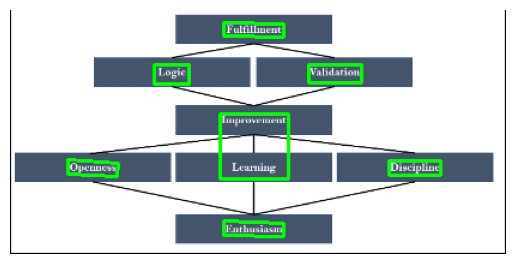

合并后检测到 7 个文本框


In [9]:
# 合并相近的文本框和文本
combined_boxes, combined_texts = combine_boxes_and_texts(image_path, distance_threshold=40)

# 绘制合并后的文本框
output_image = cv2.imread(image_path)  # 加载原始图像
for box in combined_boxes:
    box = np.array(box, dtype=np.int32)  # 将浮点数坐标转换为整数
    cv2.polylines(output_image, [box], isClosed=True, color=(0, 255, 0), thickness=2)  # 绘制绿色文本框

# 显示结果
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 输出合并后的文本框数量
print(f"合并后检测到 {len(combined_boxes)} 个文本框")


In [10]:
combined_boxes, combined_texts

([array([[178,  11],
         [228,  12],
         [228,  23],
         [178,  22]]),
  array([[120,  46],
         [149,  46],
         [149,  62],
         [120,  62]]),
  array([[249,  46],
         [293,  46],
         [293,  61],
         [249,  61]]),
  array([[175.,  87.],
         [232.,  87.],
         [232., 141.],
         [175., 141.]], dtype=float32),
  array([[ 48, 125],
         [ 90, 128],
         [ 89, 139],
         [ 48, 137]]),
  array([[316, 126],
         [359, 126],
         [359, 138],
         [316, 138]]),
  array([[178, 176],
         [228, 178],
         [228, 189],
         [178, 188]])],
 ['Fulfillment',
  'Logic',
  'Validation',
  'Improvement Learuing',
  'Opeuness',
  'Discipline',
  'Enthusiasm'])

# Module

In [11]:
class TextBoxesDetector:
    """
    A class to process text boxes detected in an image using PaddleOCR.
    It provides methods to extract, merge, and filter text boxes.
    """

    def __init__(self, image_path, distance_threshold=40):
        """
        Initializes the text box processor.
        
        :param image_path: Path to the image to process.
        :param distance_threshold: Maximum distance between two text boxes to be merged.
        """
        self.image_path = image_path
        self.distance_threshold = distance_threshold

        # Load image
        self.image = cv2.imread(image_path)
        
        # Initialize PaddleOCR
        self.ocr = PaddleOCR(use_angle_cls=True, lang="en")
        
        # Extract initial text boxes
        self.boxes, self.texts, self.scores = self._extract_text_boxes()

    def _extract_text_boxes(self):
        """
        Extract text boxes, recognized texts, and confidence scores using PaddleOCR.

        :return: Tuple of (boxes, texts, scores).
        """
        result = self.ocr.ocr(self.image, cls=True)
        
        # Extract bounding boxes, recognized text, and confidence scores
        boxes = [line[0] for line in result[0]]  # Detected text regions
        texts = [line[1][0] for line in result[0]]  # Recognized texts
        scores = [line[1][1] for line in result[0]]  # Confidence scores

        return boxes, texts, scores

    def _boxes_distance(self, box1, box2):
        """
        Compute the Euclidean distance between the centers of two text boxes.

        :param box1: Coordinates of the first text box.
        :param box2: Coordinates of the second text box.
        :return: Euclidean distance between the two box centers.
        """
        center1 = np.mean(box1, axis=0)  # Center of first box
        center2 = np.mean(box2, axis=0)  # Center of second box

        return np.linalg.norm(center1 - center2)  # Euclidean distance
    
    def combine_boxes_and_texts(self):
        """
        Merge close text boxes and concatenate their texts if within the distance threshold.
        
        :return: Dictionary {tuple(box_coordinates): merged_text}, where:
                - Key: Bounding box tuple ((x1, y1), (x2, y2), (x3, y3), (x4, y4))
                - Value: Merged text for that bounding box
        """
        combined_dict = {}  # Store box coordinates and text mapping
        used = [False] * len(self.boxes)

        for i in range(len(self.boxes)):
            if used[i]:
                continue  # Skip already merged boxes

            # Initialize current box and text
            current_box = np.array(self.boxes[i], dtype=int)
            current_text = [self.texts[i]]  # Store text as a list to append later
            used[i] = True  # Mark as merged

            for j in range(i + 1, len(self.boxes)):
                if used[j]:
                    continue

                # Compute the distance between boxes
                distance = self._boxes_distance(current_box, self.boxes[j])

                # Merge if within threshold
                if distance < self.distance_threshold:
                    # Combine box coordinates
                    combined_points = np.vstack((current_box, self.boxes[j]))
                    combined_points = np.array(combined_points, dtype=int)

                    # Ensure valid bounding box
                    if len(combined_points) >= 2:
                        try:
                            rect = cv2.minAreaRect(combined_points)
                            current_box = cv2.boxPoints(rect)  # Get the updated box

                            # Merge text
                            current_text.append(self.texts[j])  # Append the text
                            used[j] = True
                        except Exception as e:
                            print(f"Error in cv2.minAreaRect: {e}")
                            continue

            # Convert NumPy array to a tuple (so it can be used as a dictionary key)
            box_tuple = tuple(map(tuple, current_box))  # Convert to ((x1, y1), (x2, y2), ...)
            combined_dict[box_tuple] = " ".join(current_text)  # Store as key-value pair

        return combined_dict

In [12]:
textboxes = TextBoxesDetector(image_path)

[2025/03/27 21:52:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/jiazhengtian/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/jiazhengtian/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

In [13]:
combined_dict = textboxes.combine_boxes_and_texts()

In [14]:
for locs, text in combined_dict.items():
    print(f"Text: {text}")
    print(f"Bounding box coordinates: {locs}\n")

Text: Fulfillment
Bounding box coordinates: ((np.int64(178), np.int64(11)), (np.int64(228), np.int64(12)), (np.int64(228), np.int64(23)), (np.int64(178), np.int64(22)))

Text: Logic
Bounding box coordinates: ((np.int64(120), np.int64(46)), (np.int64(149), np.int64(46)), (np.int64(149), np.int64(62)), (np.int64(120), np.int64(62)))

Text: Validation
Bounding box coordinates: ((np.int64(249), np.int64(46)), (np.int64(293), np.int64(46)), (np.int64(293), np.int64(61)), (np.int64(249), np.int64(61)))

Text: Improvement Learuing
Bounding box coordinates: ((np.float32(175.0), np.float32(87.0)), (np.float32(232.0), np.float32(87.0)), (np.float32(232.0), np.float32(141.0)), (np.float32(175.0), np.float32(141.0)))

Text: Opeuness
Bounding box coordinates: ((np.int64(48), np.int64(125)), (np.int64(90), np.int64(128)), (np.int64(89), np.int64(139)), (np.int64(48), np.int64(137)))

Text: Discipline
Bounding box coordinates: ((np.int64(316), np.int64(126)), (np.int64(359), np.int64(126)), (np.int64